# P2 Feature Detection, Feature Matching and Image Warping


You are *required* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. The space limit for this assignment is **4 pages maximum**. While I don't expect this limit will pose a particular challenge for this assignment, in the future I hope that it will encourage you to think more carefully about what results you choose to include and to be more clear and succinct with your writing. You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. If I ask you to compare two algorithms or approaches, you should be thorough in your comparison, using numbers in addition to qualitative explanations whenever possible. Your response should include a discussion (in words) about how they are similar and different, but might also include a quantitative comparison if possible.

Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard**. Though it would be nice if your code were cleaned up and nicely formatted/commented, we will not likely execute your code unless we are skeptical for academic integrity reasons. We may also use your code to evaluate partial credit on multi-part assignments.

## P2.1 Harris Corners

Now that you've learned about Harris Corners, you're going to implement this procedure. For this question, **you will use the `light_cubes_base.png` and another image of your choosing for a total of 2 images**. The procedure for the Harris corner detection: 

1. Compute the gradient at each point in the image using the Sobel Filters
2. Compute the H matrix (or at least the elements of it) from the elements of the gradient
3. Compute the scoring function (perhaps by computing the eigenvalues)
4. Find points with a large response (threshold f)
5. Find local maxima of f after thresholding (you will need to pick what you think is a "reasonable" threshold; your features should be similar to those I showed in the lecture slides.)

Where the Harris matrix $H$ is defined by
$$ H = \begin{bmatrix} A & B \\ B & C \end{bmatrix} = \sum_{(x, y) \in W} w_{x, y} \begin{bmatrix}
I_x^2 & I_x I_y \\ I_x I_y & I_y^2
\end{bmatrix} $$
and $I_x$ is the $x$-derivative of the image $I$, $I_y$ is the $y$-derivative of the image $I$ and $w$ is a weight matrix. Use the Sobel filter to compute the image derivatives. You can use either definition of $f$ we introduced in class:

$$ f = min(\lambda_1, \lambda_2) $$
$$ f = \frac{\text{det}(H)}{\text{tr}(H)} $$

I have provided you with a local-maxima-finding function for you to use.

**Note that you should be completing this solution without using a Harris Corner detector package: you should be computing the image derivatives and the Harris corners themselves yourself using filters you implement, applied using the `scipy` convolution functions.** Using external packages to check your solutions is acceptable, but your answer will no doubt be slightly different than those packages.

### P2.1.1 Computing Harris Corners

**Generate two figures (a 2x2 grid for each of your images) that shows the following intermediate steps** during the computation of Harris Corners on the provided:
1. The original image
2. One of the derivatives of the image (either the $x$ and $y$ derivative will do), as computed via the Sobel filters.
3. The scoring function $f$
4. The original image with dots showing the location of the detected corners. (Be sure to choose a *reasonable* threshold; you should expect to end up with on the order of a few dozen features. If you have thousands of features, your threshold is too low. If you have only one or two features, your threshold is too high.)

For this first part, you should use a *uniform weight matrix of size 5x5* (`weights = np.ones((5, 5))/25`) when computing the scoring function. We will change this in the next part of the question. 

**QUESTION A:**
Are the features where you expected? 

**QUESTION B:**
Are there any features in the image that you are surprised are not present? Highlight or discuss in words one or two regions of one of your images where features were detected that you did not expect (or one or two regions you thought features might exist).

In class, we derived the Harris matrix and a special scoring function related to the eigenvalues of that matrix so that we could measure the *cornerness* of the image. 

**QUESTION C (IMAGES REQUIRED):**
What would happen if you used a scoring function $f = \text{tr}(H) = A + C$? Plot this alternative scoring function for the `light_cubes_base` image and plot the detected features computed using it. 

**QUESTION D:**
What does this modified scoring function detect? 

**QUESTION E:**
If we want to detect corners, why might we not want to use this scoring function?

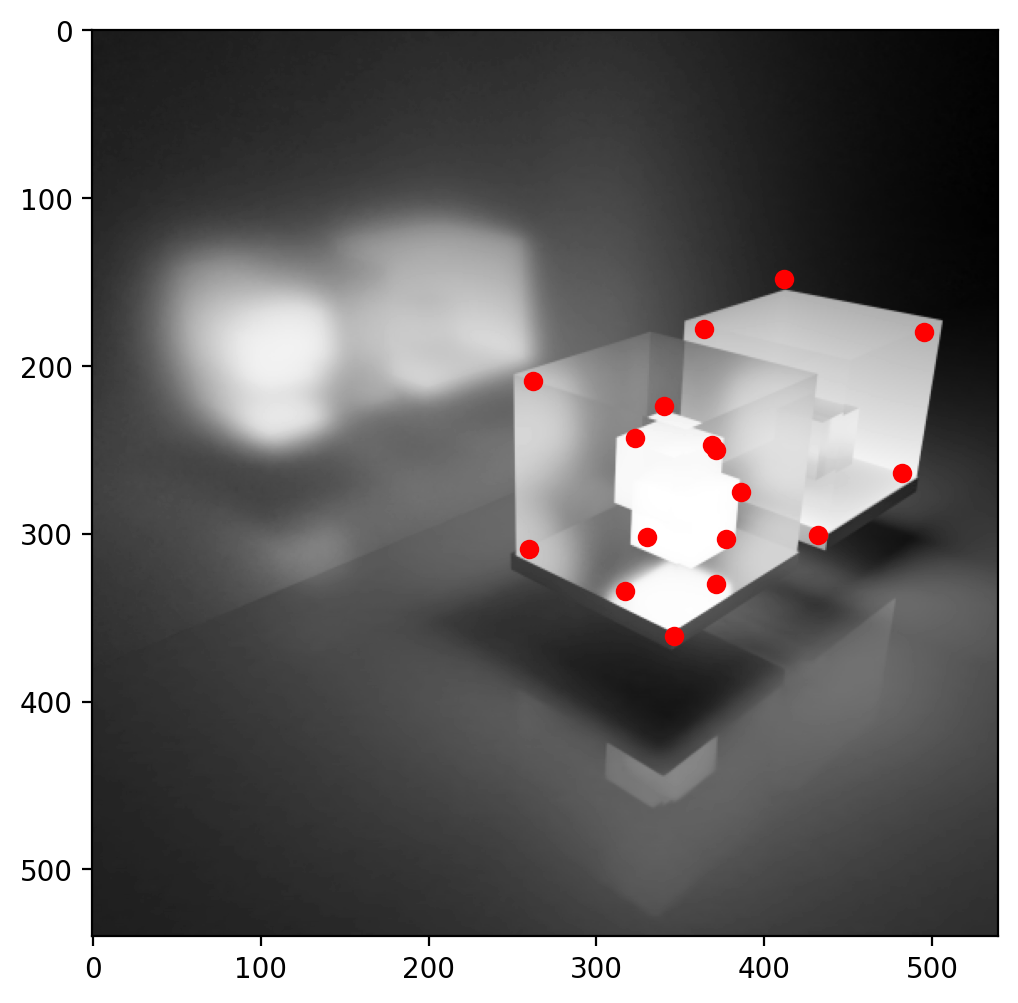

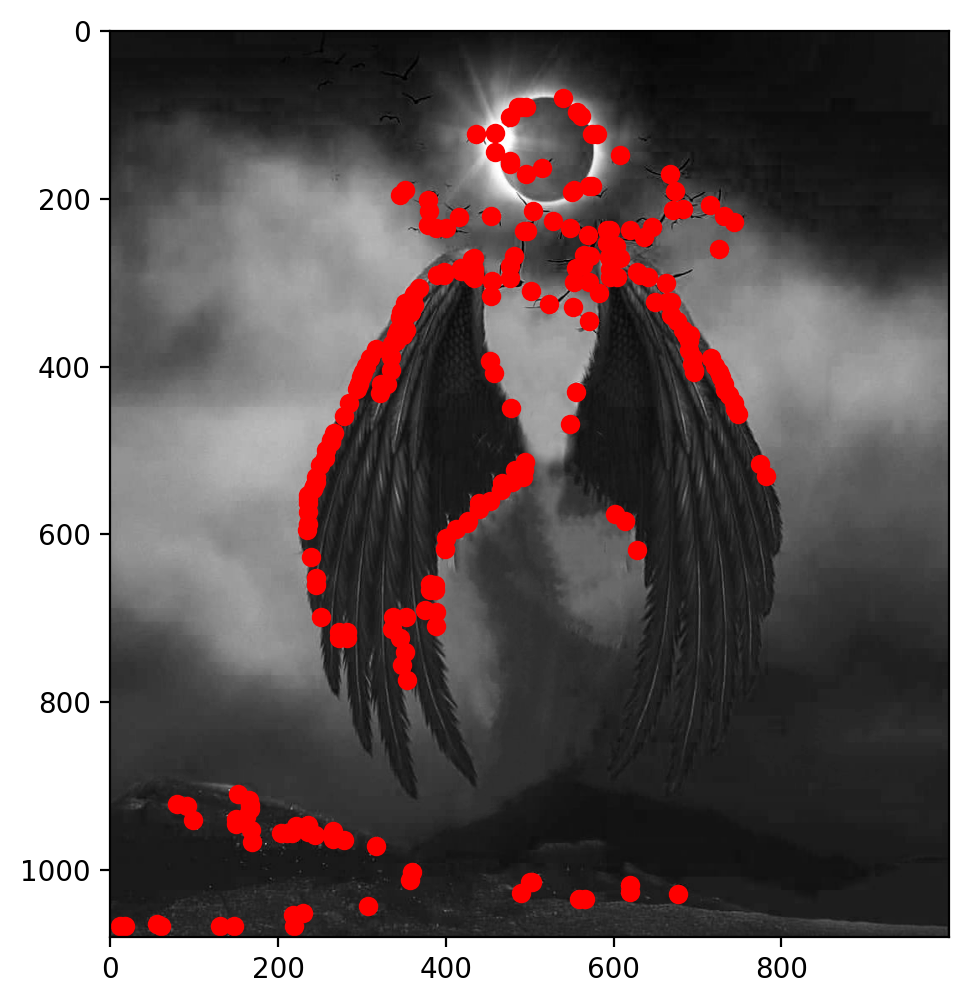

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import scipy.signal
from PIL import Image

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

image = load_image("light_cubes_sm.png")[:, :, 0]
image2 = load_image("wings.jpg")[:, :, 0]

def get_local_maxima(data, threshold):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 5

    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    for dy, dx in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        
    return np.array(list(zip(x, y)))

def convolve_images(images):
    sobel_x = np.array((
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]))
    # dtype = "int32"
    sobel_y = np.array((
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]))

    x_grad = scipy.signal.convolve(images, sobel_x, mode='same')
    y_grad=scipy.signal.convolve(images, sobel_y, mode='same')
    return x_grad, y_grad

def detect_corners(Ix, Iy, weights):
    a = scipy.signal.convolve2d(np.multiply(Ix, Ix),weights, mode="same")
    b = scipy.signal.convolve2d(np.multiply(Ix, Iy),weights, mode="same")
    c = scipy.signal.convolve2d(np.multiply(Iy, Iy),weights,mode="same")
    determinant = np.multiply(a,c) - np.multiply(b,b)
    trace = np.add(a,c)
    scoring = determinant/trace
    return scoring

weights = np.ones((5, 5))/25
# weights = np.ones((1,1))/1

x_grad, y_grad = convolve_images(image)

result = detect_corners(x_grad, y_grad, weights)
# fig = plt.figure(figsize=(5, 5), dpi=300)
# plt.subplot(232)
# plt.imshow(result)
# plt.title('Scoring function f')

fig = plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(image, cmap='gray')
points = get_local_maxima(result, threshold=0.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
# plt.plot(points, 'ro')
plt.show()

x_grad2, y_grad2 = convolve_images(image2)

result2 = detect_corners(x_grad2, y_grad2, weights)
# fig = plt.figure(figsize=(5, 5), dpi=300)
# plt.subplot(232)
# plt.imshow(result)
# plt.title('Scoring function f')

fig = plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(image2, cmap='gray')
points = get_local_maxima(result2, threshold=0.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

### P2.1.2 Varying the Weight Matrix

In this part, we will see what happens when we use different weight matrices. **Using only the `light_cubes_base` image, plot the score function $f$ (one of the ones we discussed in class) and the detected corners for each of the following weight function**:

1. A uniform weight matrix of size 5x5 `weights = np.ones((5, 5))/(5**2)` (same as in the previous question).
2. A uniform weight matrix of size 25x25 `weights = np.ones((25, 25))/(25**2)`
3. A Gaussian weight matrix with $\sigma = 5$
4. A Gaussian weight matrix with $\sigma = 50$

**QUESTION A:**
Discuss the differences between these four weight functions. In particular, what happens when the filter width (or $\sigma$) is very large?

**QUESTION B:**
What happens if we were to use a 1x1 weight matrix $w = 1$? Why does this occur?

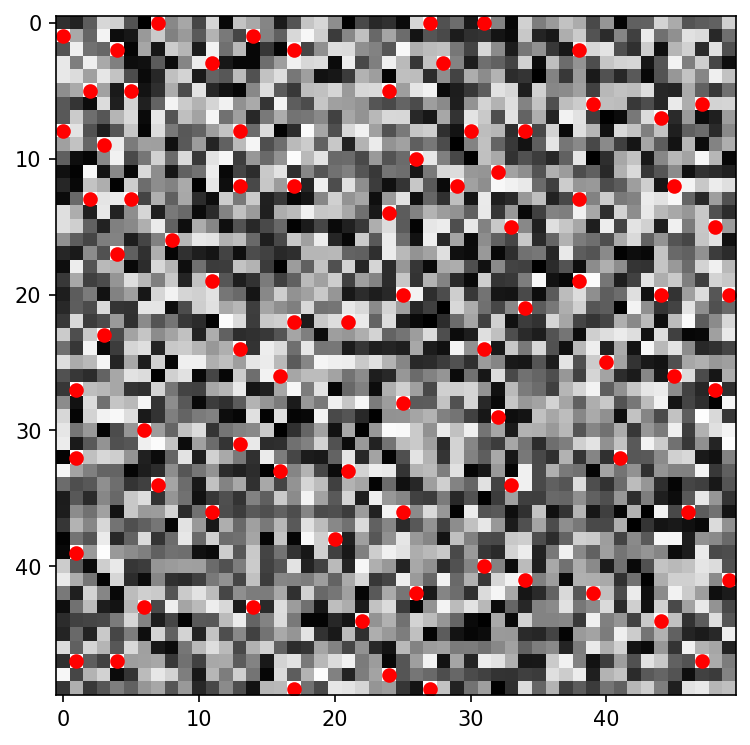

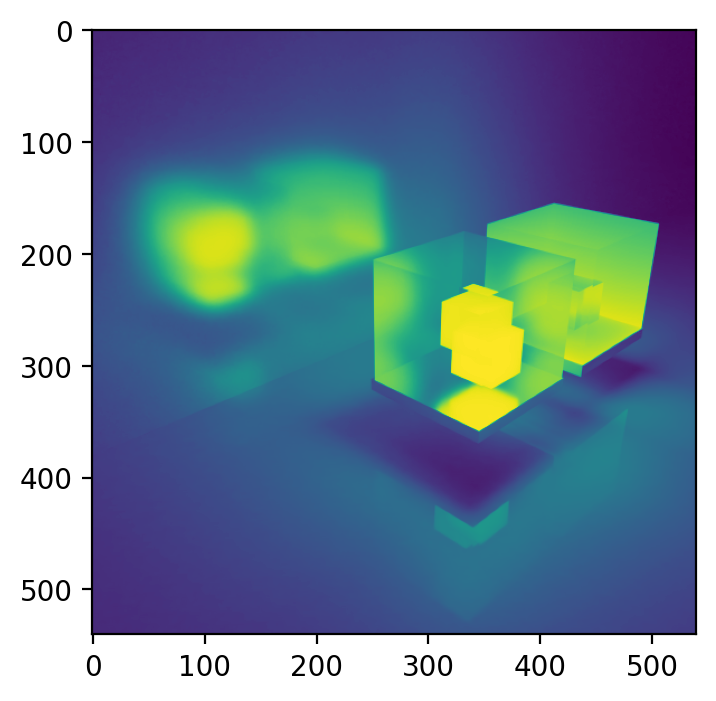

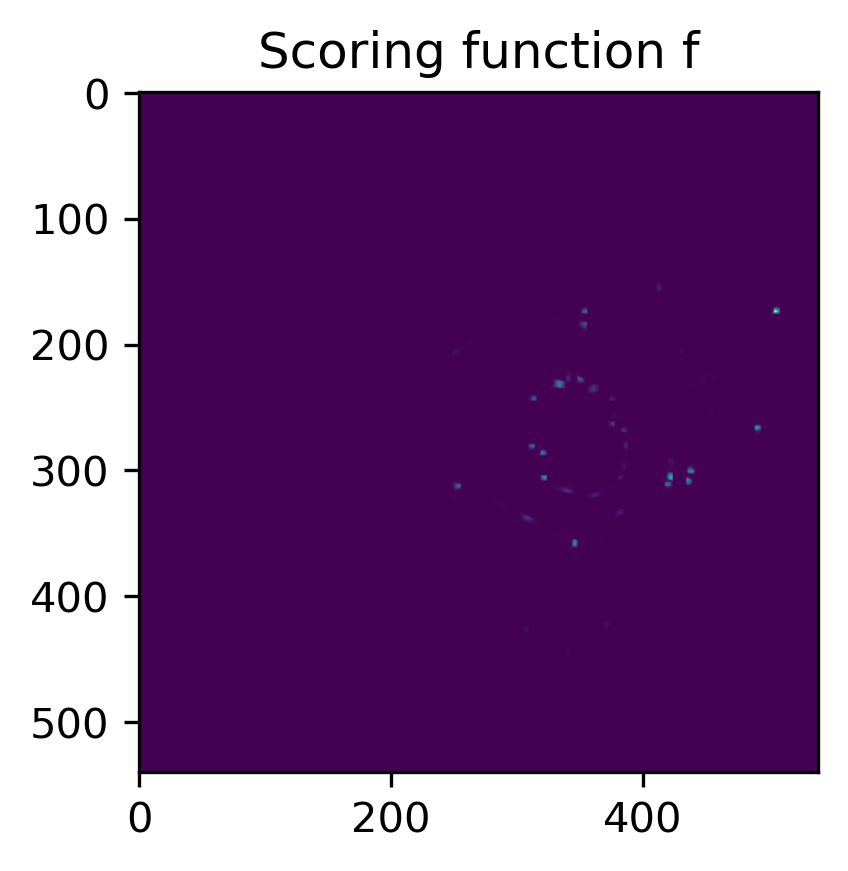

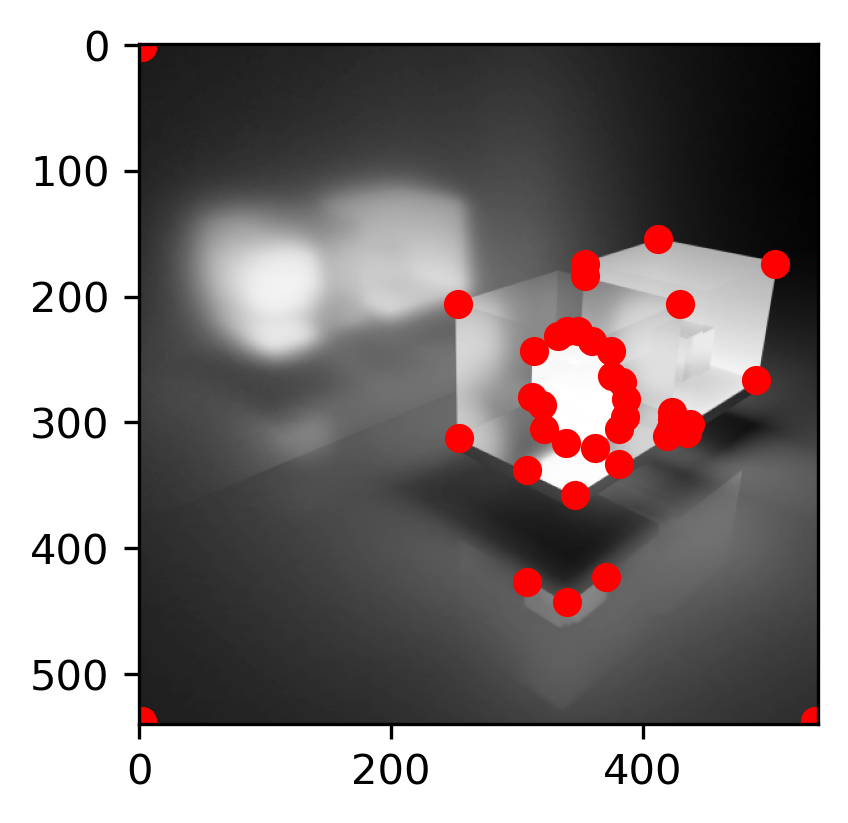

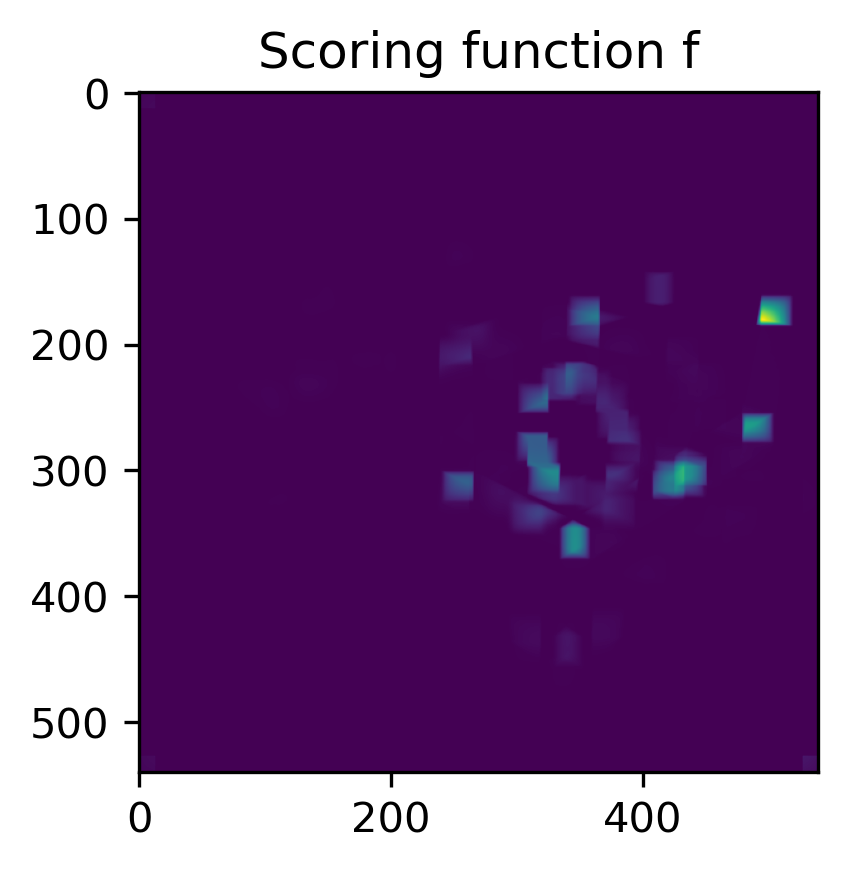

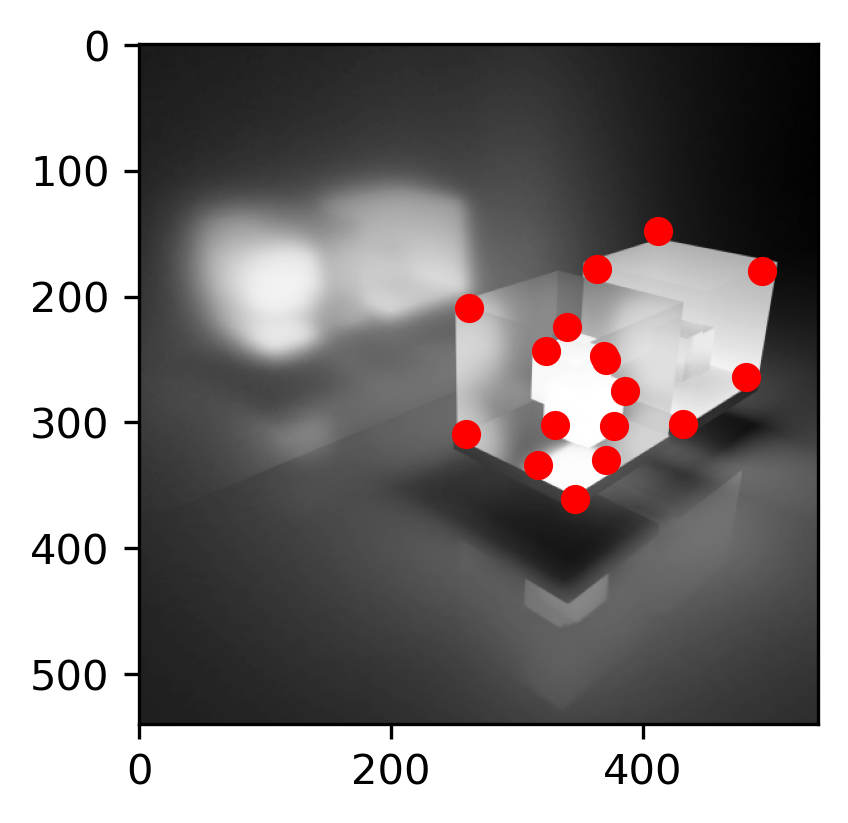

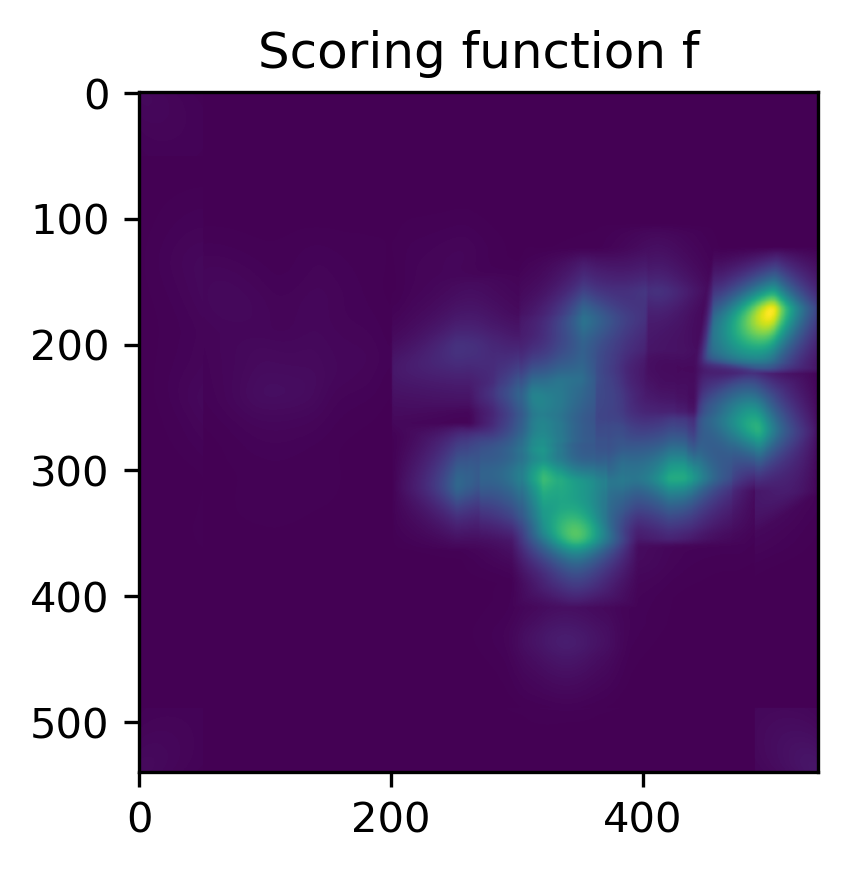

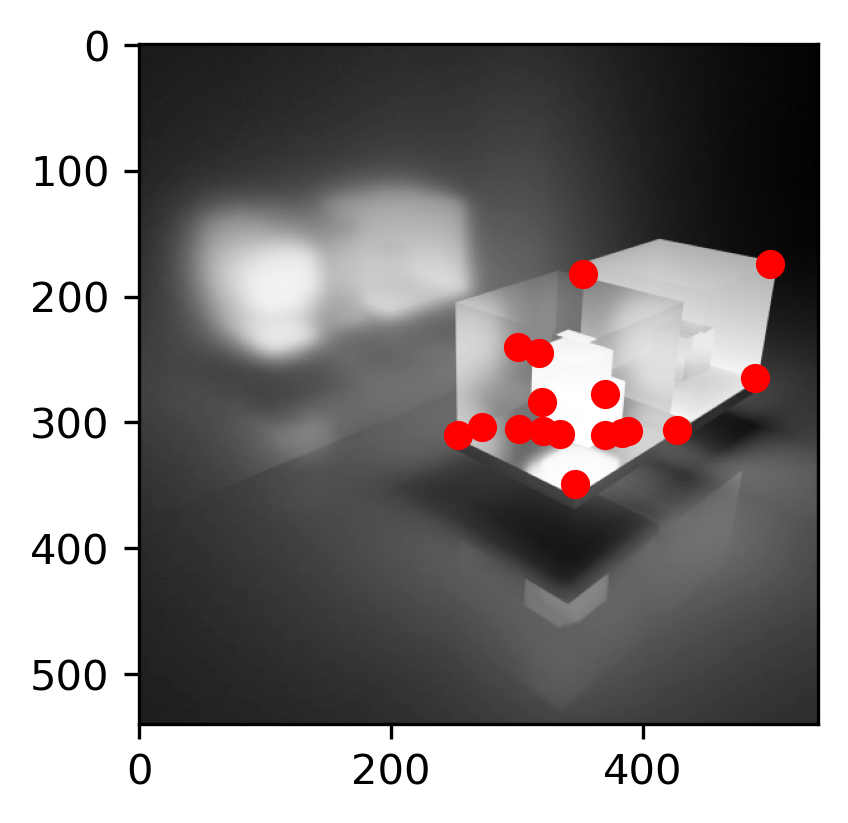

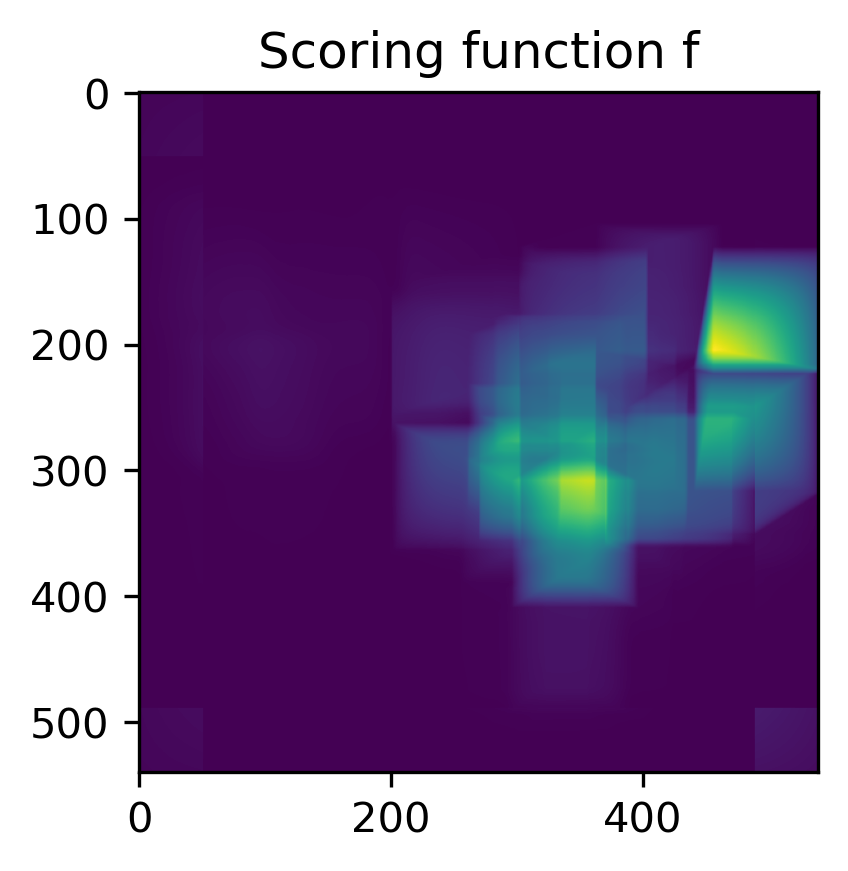

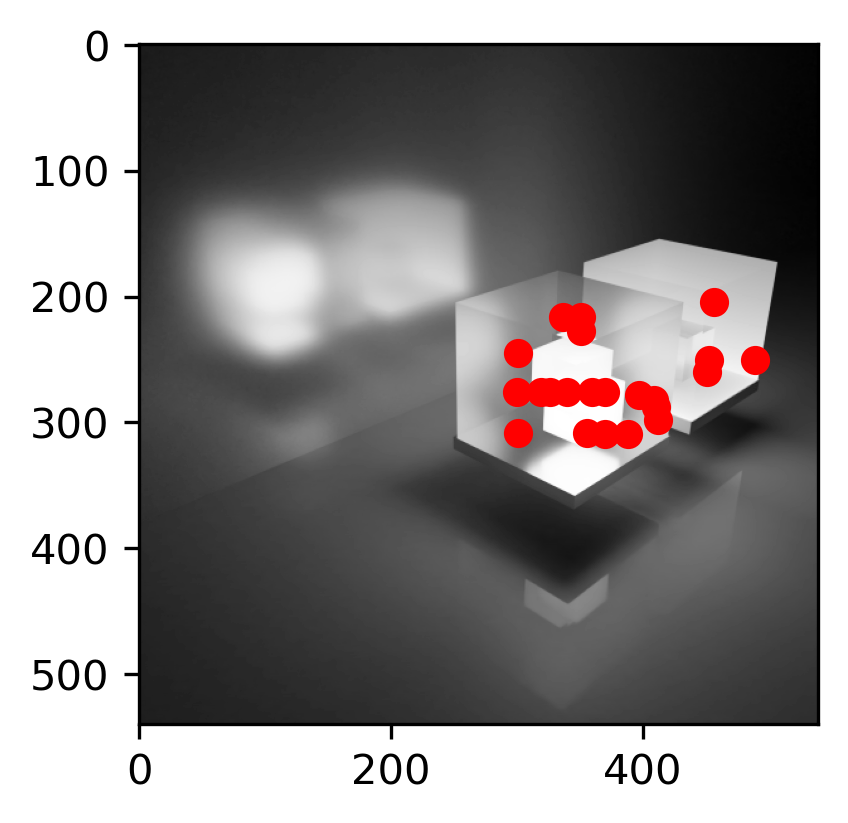

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal
import scipy.ndimage.filters as filters

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

def get_local_maxima(data, threshold):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 5

    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    for dy, dx in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        
    return np.array(list(zip(x, y)))

def get_gaussian_filter(n, sigma=1):
    n = 2 * (n//2) + 1
    h = (n + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d*2 + d.T * 2
    # Take the gaussian
    g = np.exp(-d_sq/2/(sigma**2))
    # Normalize
    g = g/g.sum().sum()
    return g
# Some example code showing that it works
signal = np.random.rand(50, 50)
fig = plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(signal, cmap='gray')
points = get_local_maxima(signal, threshold=0.95)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

image = load_image("light_cubes_sm.png")[:, :, 0]
plt.figure(dpi=200)
plt.imshow(image)
plt.show()

weights = np.ones((5, 5))/25
weights2 = np.ones((25, 25))/(25**2)
weights3 = get_gaussian_filter(100, 5)
weights4 = get_gaussian_filter(100, 50)

x_grad, y_grad = convolve_images(image)

result = detect_corners(x_grad, y_grad, weights)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(result)
plt.title('Scoring function f')

fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(image, cmap='gray')
points = get_local_maxima(result, threshold=.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

result2 = detect_corners(x_grad, y_grad, weights2)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(result2)
plt.title('Scoring function f')

fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(image, cmap='gray')
points = get_local_maxima(result2, threshold=.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

result3 = detect_corners(x_grad, y_grad, weights3)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(result3)
plt.title('Scoring function f')

fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(image, cmap='gray')
points = get_local_maxima(result3, threshold=.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()

result4 = detect_corners(x_grad, y_grad, weights4)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(result4)
plt.title('Scoring function f')

fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(image, cmap='gray')
points = get_local_maxima(result4, threshold=.015)
plt.plot(points[:, 0], points[:, 1], 'ro')
plt.show()
None

## P2.2 Multi-scale Blob Detection

Here, we will be building on the in-class breakout session to experiment with using the (normalized) Laplacian of Gaussian (LoG) filter to detect "blobs" in an image and their scale.

### P2.2.1 Scale-Normalized Filter Response

In this question, I have provided you with a simple "circle image", in which a filled circle is placed at the center of a square image. Here, you know that the circle is the feature you are trying to detect and that its location is at the center, so the feature does not need to be *located*. Instead, you are asked to **find the radius of the circle** (the "blob feature" of interest).

The steps are detailed below:
1. First, you will need to define the LoG filter function `get_LoG_filter(kernel_size, sigma)` using either the in-class notes or [this resource](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm). 
2. Once you have computed the normalized LoG filter, apply it at multiple scales to the sample circle image I have provided you with and **plot a few of the filtered images**. 
3. **(GRAPH REQUIRED)** Plot "filter response" (the value of the image after the filter is applied) at the center of the circle versus $\sigma$. Confirm that the peak of the filter response at the center of the circle occurs at the $\sigma$ we expect. (Recall that the peak $\sigma$ value does not correspond to the radius of the circle).

**QUESTION A:**
What is the relationship between the peak $\sigma$ and the circle's radius?


**Note:** If you use the *unnormalized Laplace of Gaussian Filter*, the maximal feature response will not occur where you expect. Be sure to use the correct filter function.

<Figure size 432x288 with 0 Axes>

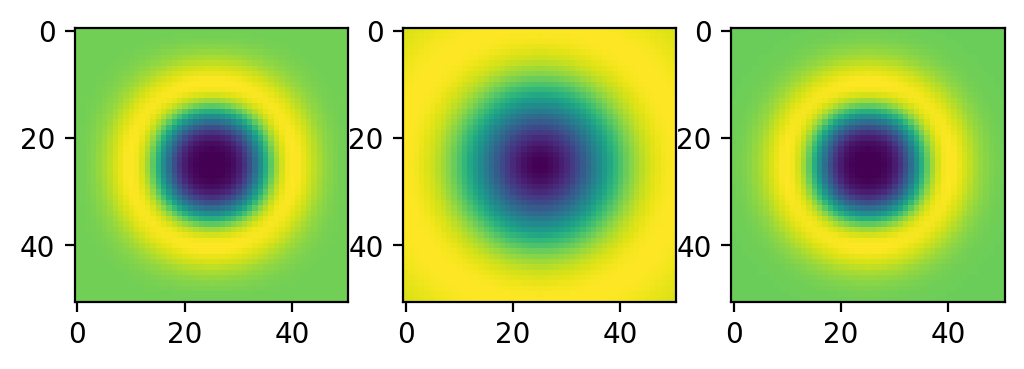

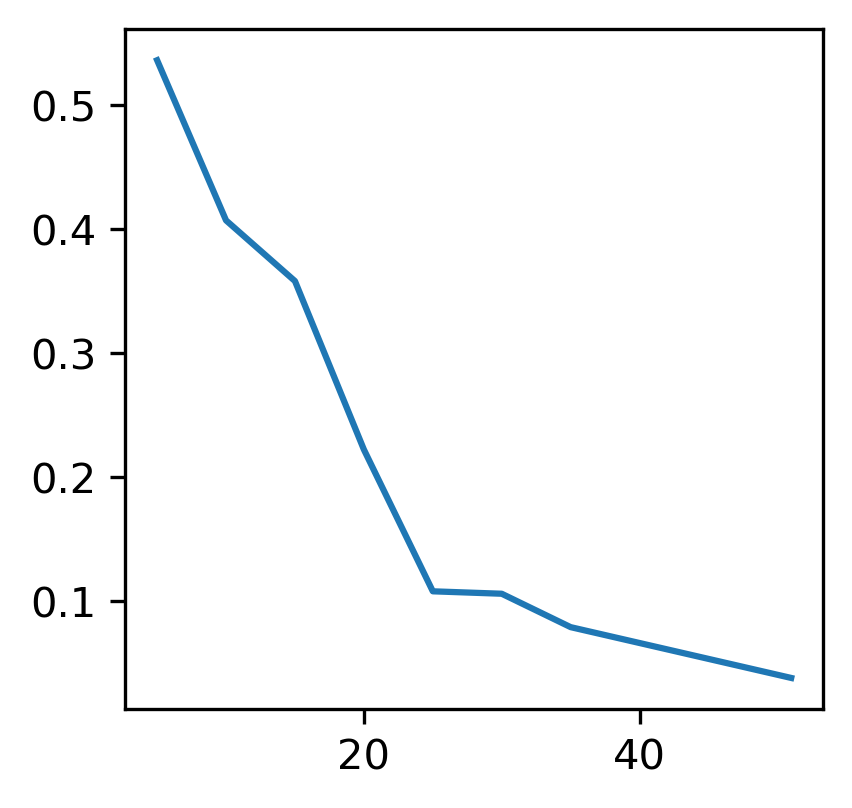

In [142]:
## import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def get_circ_image(image_size, radius):
    """Create an image of width `image_size` with a circle 
    of radius `radius` in its center."""
    assert(image_size % 2 == 1)
    h = (image_size + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis] 
    d_sq = d**2 + d.T ** 2
    # Threshold by squared radius
    d_sq = (d_sq <= radius**2).astype(np.float)
    return d_sq

def get_LoG_filter(kernel_size, sigma):
    n = kernel_size
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

def apply_filter(signal, filt):
    """Apply a filter to an image; wrapper around scipy."""
    return scipy.signal.convolve2d(signal, filt, mode='same')

im_half_size = 25
fig = plt.figure()
circ_img = get_circ_image(2 * im_half_size + 1, radius=10)
fig = plt.figure(figsize = (6,6), dpi = 200)
plt.subplot(231)
plt.imshow(apply_filter(circ_img, get_LoG_filter(30, 5)))
plt.subplot(232)
plt.imshow(apply_filter(circ_img, get_LoG_filter(72, 12)))
plt.subplot(233)
plt.imshow(apply_filter(circ_img, get_LoG_filter(40, 5)))


filterResponse = []
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(30,5))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(12,10))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(50,15))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(20,20))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(14,25))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(70,30))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(100,35))).max())
filterResponse.append(np.abs(apply_filter(circ_img, get_LoG_filter(42,51))).max())

sigma = [5,10,15,20,25,30,35,51]

fig = plt.figure(figsize = (3,3), dpi = 300)
plt.plot(sigma, filterResponse)
None

###  P2.2.2 Annotating an Image with Multi-Scale Detections

Now, let's assume that we have an image with multiple features and we don't know either where they are or what their "radius" or "scale" is. Your goal here is to simultaneously detect features and estimate their characteristic scale.

For testing purposes, I have provided you with a simple image with two circles in it. Your task is to automatically identify where these "blobs" are and what their radius is. By the time you're done, you should be able to automatically detect the feature locations *and* their scale, producing images like the following: 

<img src="auto_feature_detection_result.png" width="400">

Similar to the Harris Features from the last exercise, the features occur at extrema (both maxima and minima) in image-space. Before we compute multi-scale features, pick 3 or 4 values of $\sigma$ and for each, plot the following:
1. **(IMAGES REQUIRED)** The filter response (applying the scaled LoG filter for a particular $\sigma$ to the image function) and;
2. **(IMAGES REQUIRED)** The location of the extrema plotted on top of the original image (just like the Harris Corner exercise from the previous programming assignment). To compute the corners, you may use the `get_local_maxima` function I have provided (the same as from the last assignment).

Now, we can put everything together. The multi-scale features we care about exist at extrema in both image space *and* in scale space. This will require computing the "blob" feature response in both image-space and in scale space (by iterating through different sigma values). Features will exist at extrema of $f$ in both image space and scale space. Your code for multi-scale blob detection will look something like the following:

```python
response = np.zeros(
    [image.shape[0], image.shape[1], sigmas.size]
)
for ii, sigma in enumerate(sigmas):
   filter_kernel = get_LoG_filter(kernel_size, sigma)
   filtered_image = apply_filter_to_image(image, filter_kernel)
   # Store the absolute value (both large positive 
   # and negative responses correspond to features).
   response[:, :, ii] = np.abs(feature_response)
   
features = get_local_maxima_3D(response)
```

Where you should implement the functions `get_LoG_filter` and `apply_filter_to_image`. I have provided you with `get_local_maxima_3D` (which I wrote by extending the 2D version I have provided above).

**Once you have computed the features, plot them as circles of the appropriate radius on top of three images**: (1) the two-circle "test" image I have provided, (2) either the "sunflower_field.jpg" image or the "light_cubes_base.png" image I have provided in this folder, and (3) an image of your choosing.

[This resource](https://www.delftstack.com/howto/matplotlib/how-to-plot-a-circle-in-matplotlib/#matplotlib-patches-circle-method-to-plot-a-circle-in-matplotlib) will help you in drawing circles in matplotlib.

[[-0.0127324]]


NameError: name 'apply_filter_to_image' is not defined

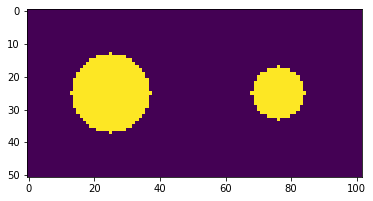

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.ndimage.filters as filters


def get_local_maxima_3D(data, threshold, sigmas, neighborhood_size=5):
    # See: https://stackoverflow.com/a/9113227/3672986
    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)

    features = []
    x, y = [], []
    for dy, dx, dz in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        y_center = int(round((dy.start + dy.stop - 1)/2))
        z_center = int(round((dz.start + dz.stop - 1)/2))
        features.append((x_center, y_center, sigmas[z_center]))
    return features

fig = plt.figure()
sigmas = np.arange(2, 20, 0.1)
circ_img_a = get_circ_image(2 * im_half_size + 1, radius=12)
circ_img_b = get_circ_image(2 * im_half_size + 1, radius=8)
circ_img = np.concatenate([circ_img_a, circ_img_b], axis=1)
plt.imshow(circ_img)

# self-written code
sigma1 = 5
sigma2 = 10
sigma3 = 15
sigma4 = 20
sigmas = [sigma1, sigma2, sigma3, sigma4]

response = np.zeros(
    [circ_img.shape[0], circ_img.shape[1], 4]
)
for ii, sigma in enumerate(sigmas):
    filter_kernel = get_LoG_filter(ii, sigma)
    filtered_image = apply_filter_to_image(image, filter_kernel)
    response[:, :, ii] = np.abs(feature_response)

features = get_local_maxima_3D(response)

None

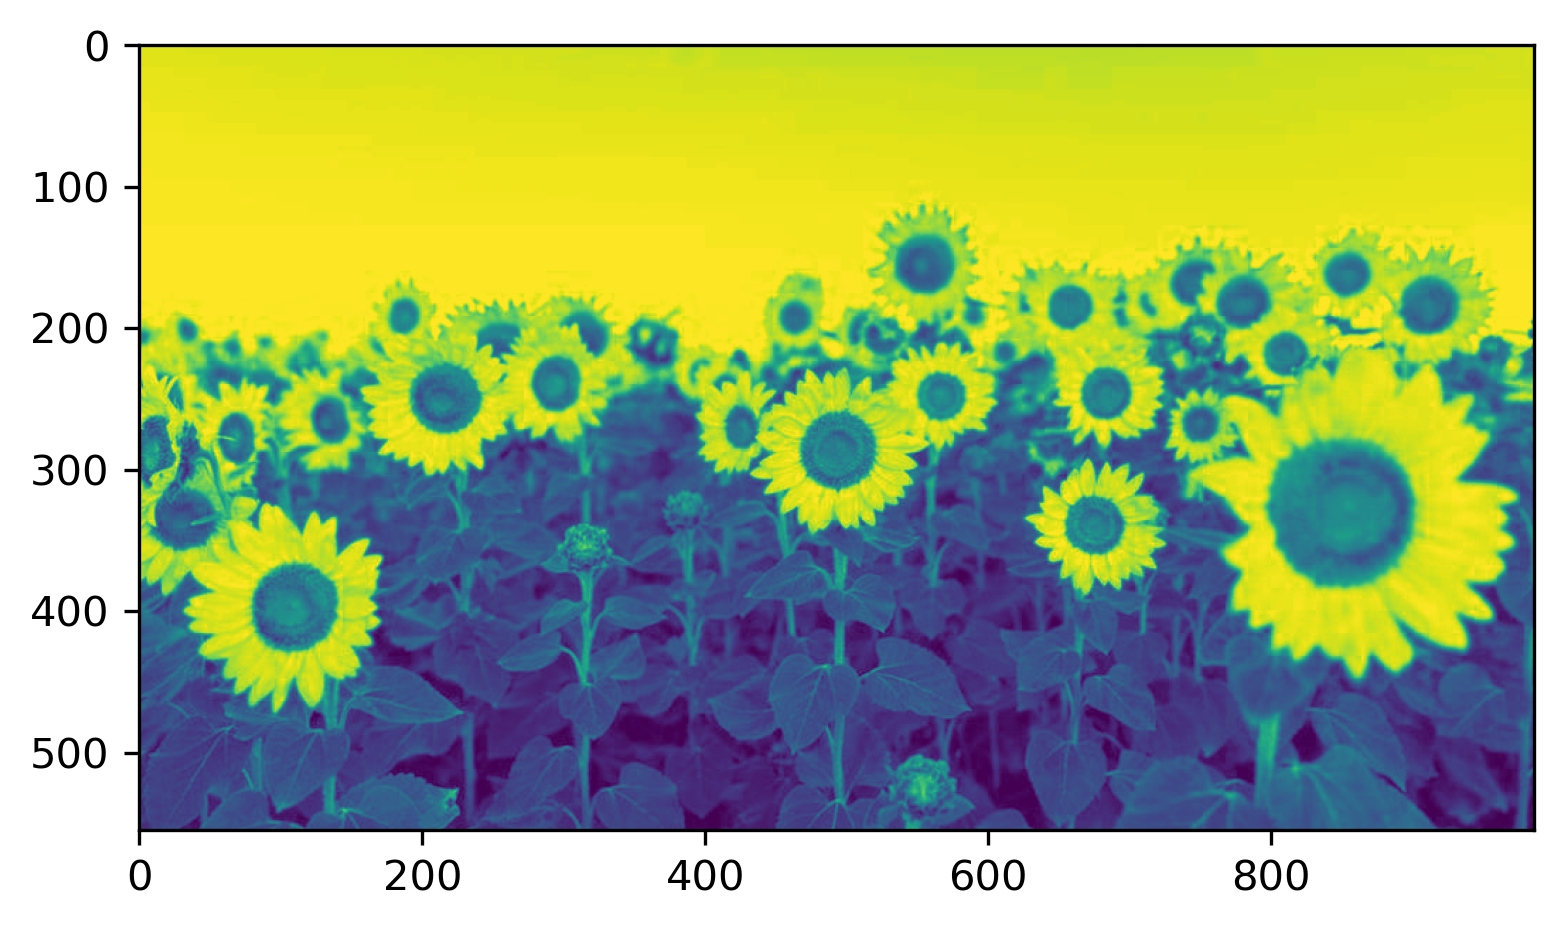

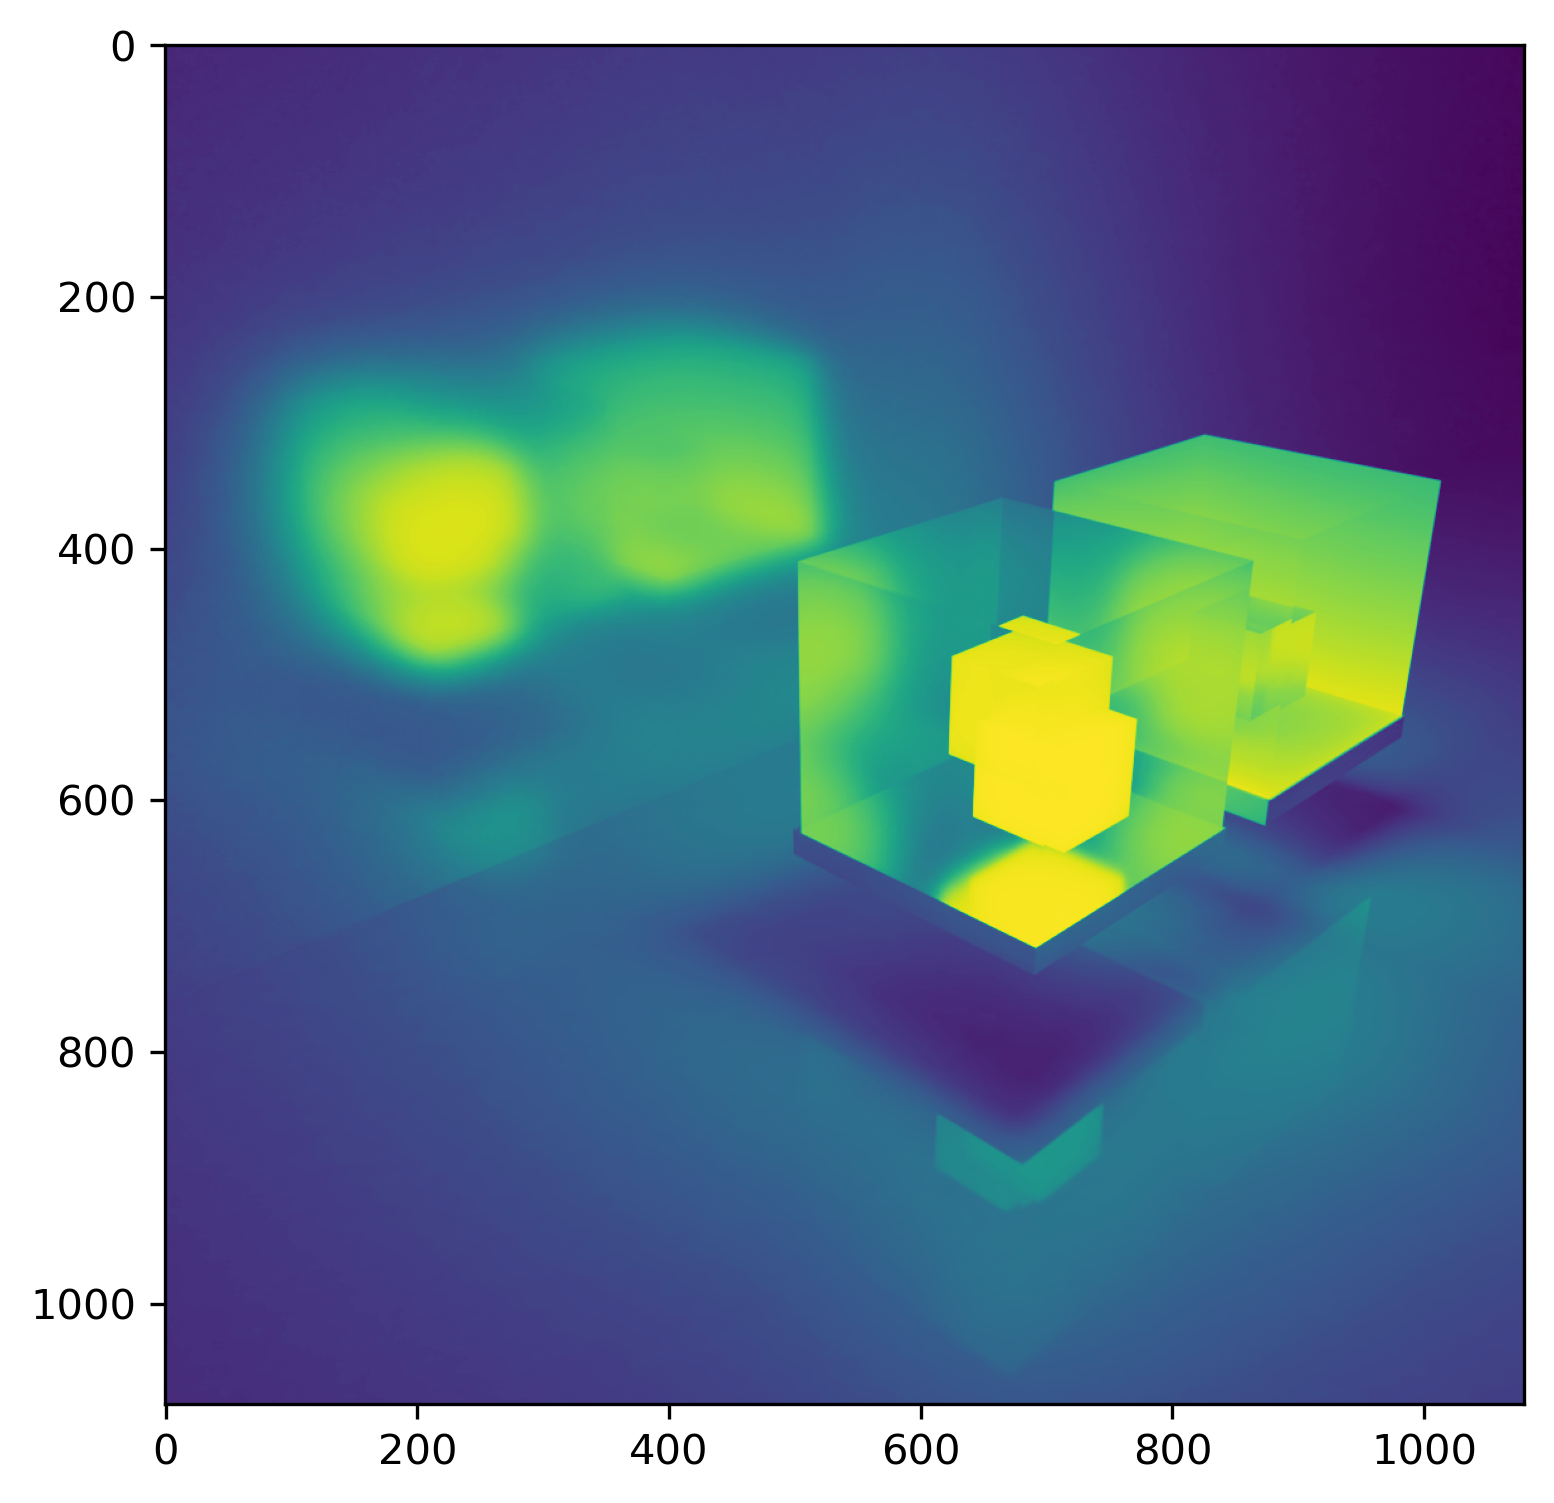

In [36]:
# Images for multi-scale feature detection.
# Sunflower Image from: https://local12.com/news/local/deerfield-township-sunflower-field-attracts-shutterbugs
image_base = load_image("sunflower_field.jpg")[:, :, 0]
fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(image_base)

image_base = load_image("light_cubes_base.png")[:, :, 0]
fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(image_base)

None

## P2.3 Image Warping

In this question, we will pick up where we left off from the in-class breakout session. You are tasked with writing a `transform_image` function that takes as input an `image` and `transformation_matrix`. The function takes in an image and transforms it according to the `transformation_matrix`.

Using the `upsample_image` function I have provided below, write a new function `transform_image` that applies a transformation matrix to an image. You should feel free to use `scipy` for interpolation, **but you may not use `scipy` for anything other than the convolution, peak detection, and interpolation. You should also not use `opencv` for any of the following**.

> Note: you will notice in the comments in the provided function that there is a convention difference you need to keep track of: the `image` is stored in (row, column) coordinates, which is different from the transformation matrix, typically stored in (x, y) coordinates.

Your goal, once this function is written, is to **implement the following transformation kernels, apply them to an image of your choosing, plot the resulting transformed image, and describe any surprising behavior of the kernels**:

1. The identity: $$\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix}$$
2. A rotation by 30 degrees
3. A rotation by 30 degrees and translated to the center
4. Scale by a factor of 2 along the x-axis
5. This kernel (which you should describe): $$\begin{bmatrix} 1 & -1 & 0 \\ 1 & 1 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix}$$

Be sure to include the transformation matrices in your writeup.

> *Note* The `xi` and `yi` parameters (defined in the `transform_image` function below). control the bounds of the output image. If you'd like, you can change the domain of the output image by experimenting with `xi` and `yi` and see how, by changing them, you can make the rotated images fit in the entire output image. (Doing so is *not* a required part of the assignment.)

Finally, experiment with homography transforms, by modifying the bottom row of the transformation matrix. Define two different homography transforms, write out their matrices and display the results. 

**QUESTION A:**
How do the two "bottom row" parameters control how the image is warped?

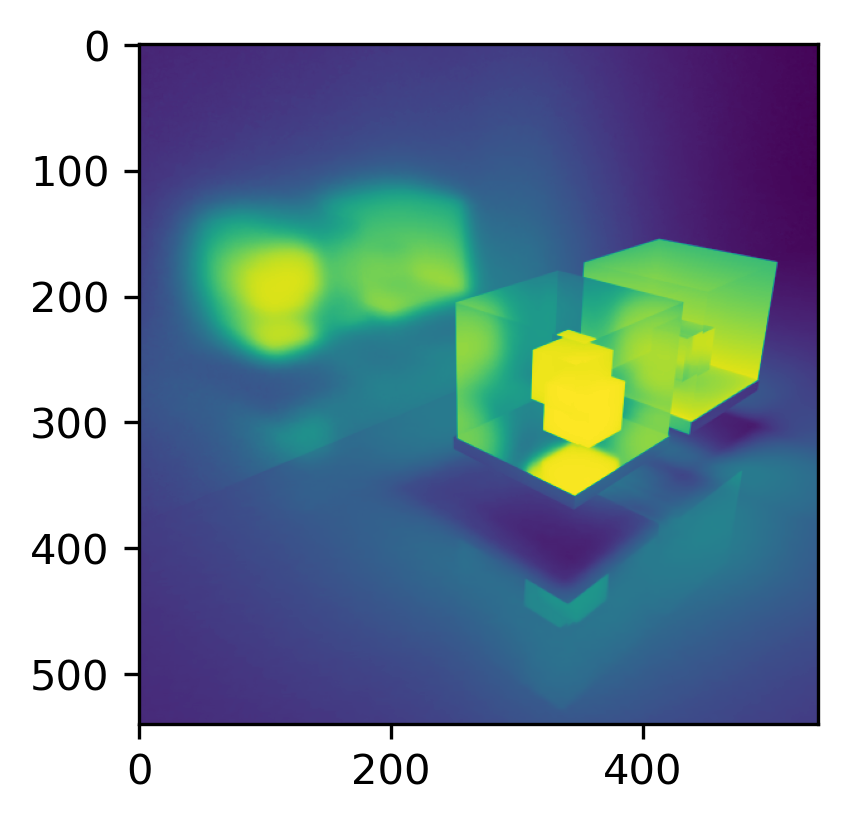

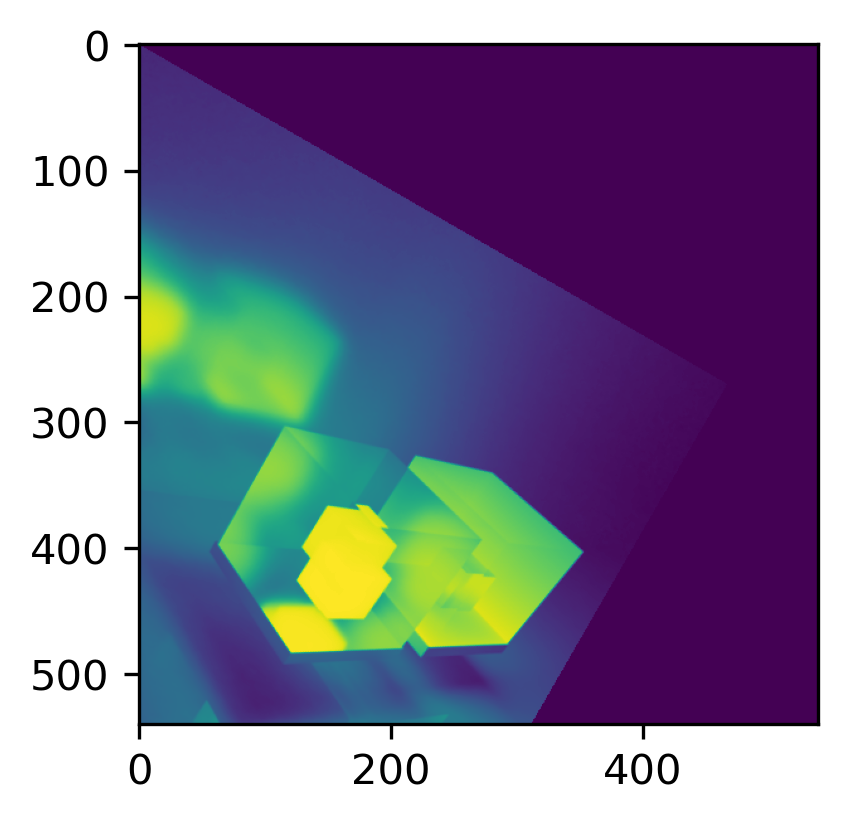

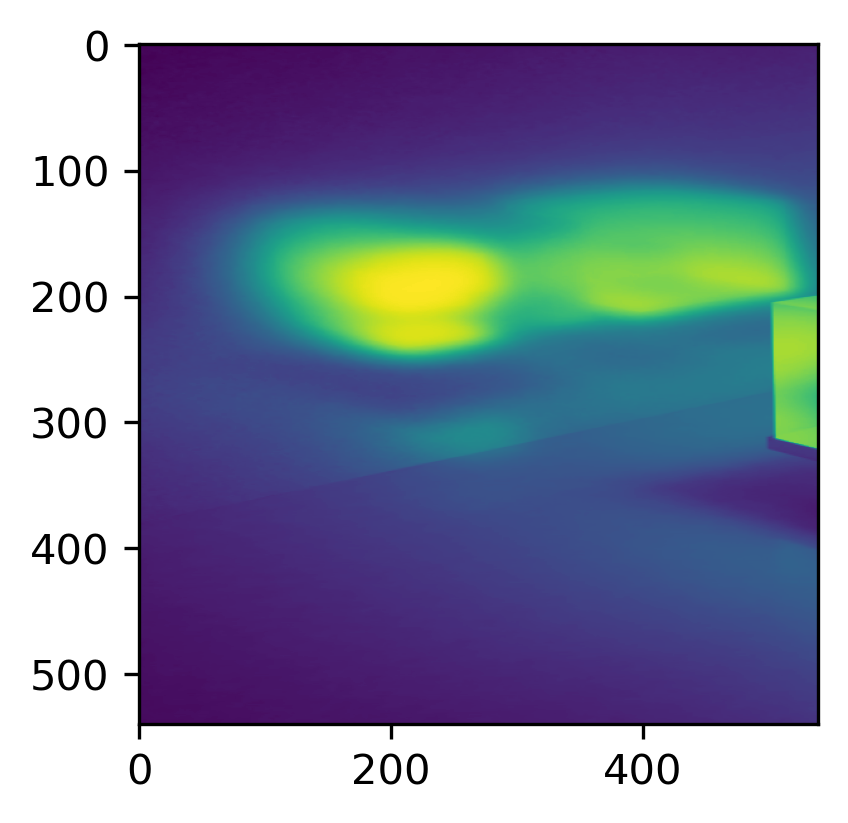

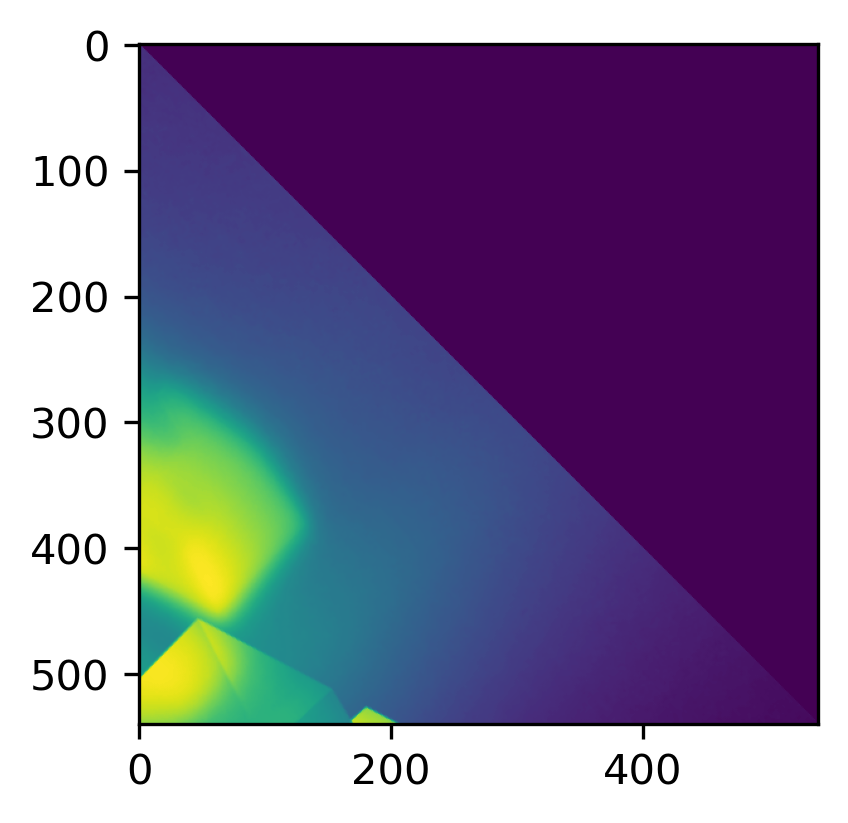

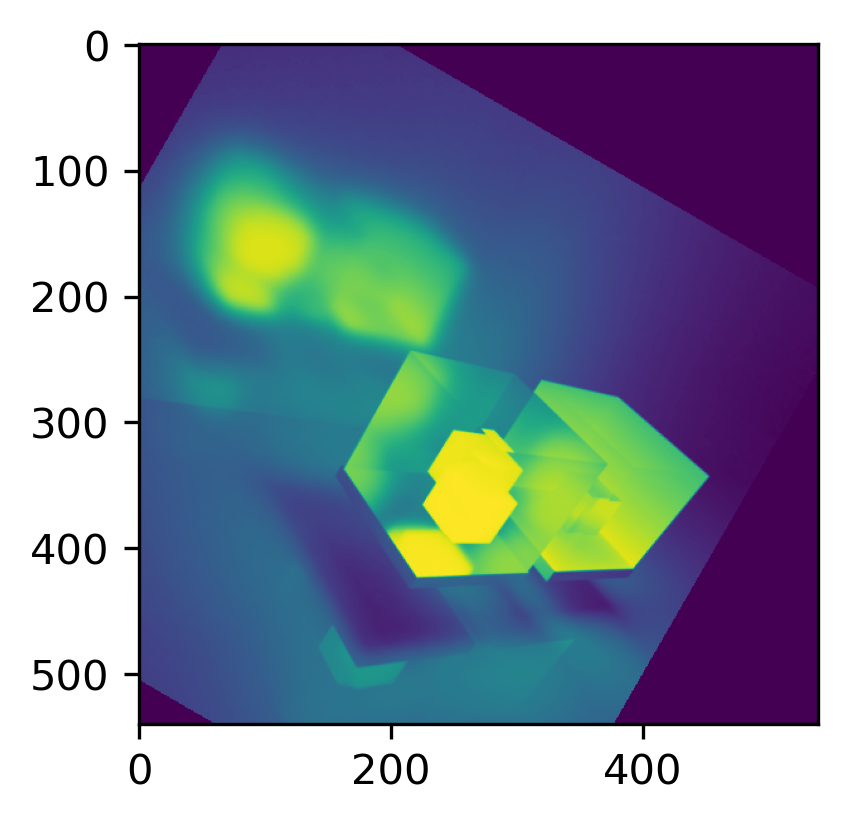

In [144]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
from PIL import Image

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

def upsample_image(image, target_shape, interp_fn):
    # Initialize the upsampled image
    image_up = np.zeros(target_shape)
    
    # Define the new coordinates (using the [y, x] convention
    # since image matrices are defined [row, column])
    new_xs = np.linspace(0, image.shape[1]-1, 
                         target_shape[1], endpoint=True)
    new_ys = np.linspace(0, image.shape[0]-1, 
                         target_shape[0], endpoint=True)
    
    # Loop through coordinates and set the image values
    for ix, new_x in np.ndenumerate(new_xs):
        for iy, new_y in np.ndenumerate(new_ys):
            image_up[iy, ix] = interp_fn(image, new_x, new_y)
            
    return image_up

identityMatrix = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

#rotation by 30 degrees
rotated30 = np.array([
    [math.sqrt(3)/2,-1/2, 0],
    [1/2,math.sqrt(3)/2, 0],
    [0, 0, 1]
])

center = np.array([
    [math.sqrt(3)/2,-1/2, 100],
    [1/2,math.sqrt(3)/2, -60],
    [0, 0, 1]
])

scaled2Xaxis = np.array([
    [2, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

rotate45 = np.array([
    [1, -1, 0],
    [1, 1, 0],
    [0, 0, 1]
])


def transform_image(image, transformation_matrix):
    # Notice that because matrices are stored "rows, columns",
    # we need to flip the "shape" coordinates so that the transformation
    # matrix does what we expect. The other convention is also acceptable,
    # as long as one is consistent. In this function, the transformation
    # matrix is assumed to be in [x, y, w] coordinates, even though the image
    # is stored in row, column (y, x) coordinates.
    sh = image.shape
    x = np.arange(image.shape[1]).astype(np.float)
    y = np.arange(image.shape[0]).astype(np.float)
    
    # For now, the dimensions of the output image will
    # remain unchanged. Modify xi and yi to change the
    # domain of the output image.
    xi = np.arange(image.shape[1]).astype(np.float)
    yi = np.arange(image.shape[0]).astype(np.float)

    # Perform the transformation
    image_fn = scipy.interpolate.interp2d(x, y, image, fill_value=0)
    transformed_image = np.zeros((len(yi), len(xi)))
    inversed = np.linalg.inv(transformation_matrix) #Inverse transformation matrix
    for new_x_coord in xi: #loop through new pixel values
        for new_y_coord in yi:
            
            new_coords = np.array([new_x_coord, new_y_coord, 1])
            coords_in_old_image = inversed @ new_coords
            
            x_interpolation = coords_in_old_image[0]
            y_interpolation = coords_in_old_image[1]
            
            transformed_image[int(new_y_coord)][int(new_x_coord)] = image_fn(x_interpolation, y_interpolation)
    
    return transformed_image

image = load_image("light_cubes_sm.png")[:, :, 0]

transformed = transform_image(image, identityMatrix)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(transformed)

transformed = transform_image(image, rotated30)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(transformed)

transformed = transform_image(image, scaled2Xaxis)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(transformed)

transformed = transform_image(image, rotate45)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(transformed)

transformed = transform_image(image, center)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.imshow(transformed)

## P2.4 Experimenting with Some Simple Feature Descriptors

In class you learned about some different strategies for describing features; now we're going to implement them and see how well they perform under different image transformations. Here are the relevant slides from class:

<img src="descriptors_overview.png" width="600">

Compute some of the simple image descriptors we discussed in class  and see how effective they are at matching features across different image transformations. To locate the features, use your Harris Corner detector from question P2.1. I have provided code that computes the feature descriptors for small image patches surrounding each of your features using three of these strategies. I have also included code under `Descriptor Matching Plotting Code` that plots the matches for a set of test images.

**TASK** Implement the `get_corners` function (in the code block named `Computing and Matching Descriptors`) using your Harris Corner detection solution from P2.1. If that function is implemented properly, you should be able to generate plots showing match quality.

**FIGURES** Once you have implemented `get_corners` the code below should generate plots for the three different descriptors. Include all three in your writeup.

**QUESTION A** Which feature descriptor performs poorly on the image `img_contrast`? Explain why this descriptor performs worse than the others.

**QUESTION B** Which feature descriptor performs best on the image `img_transpose`? Explain why this descriptor performs better than the others.

TypeError: 'int' object is not callable

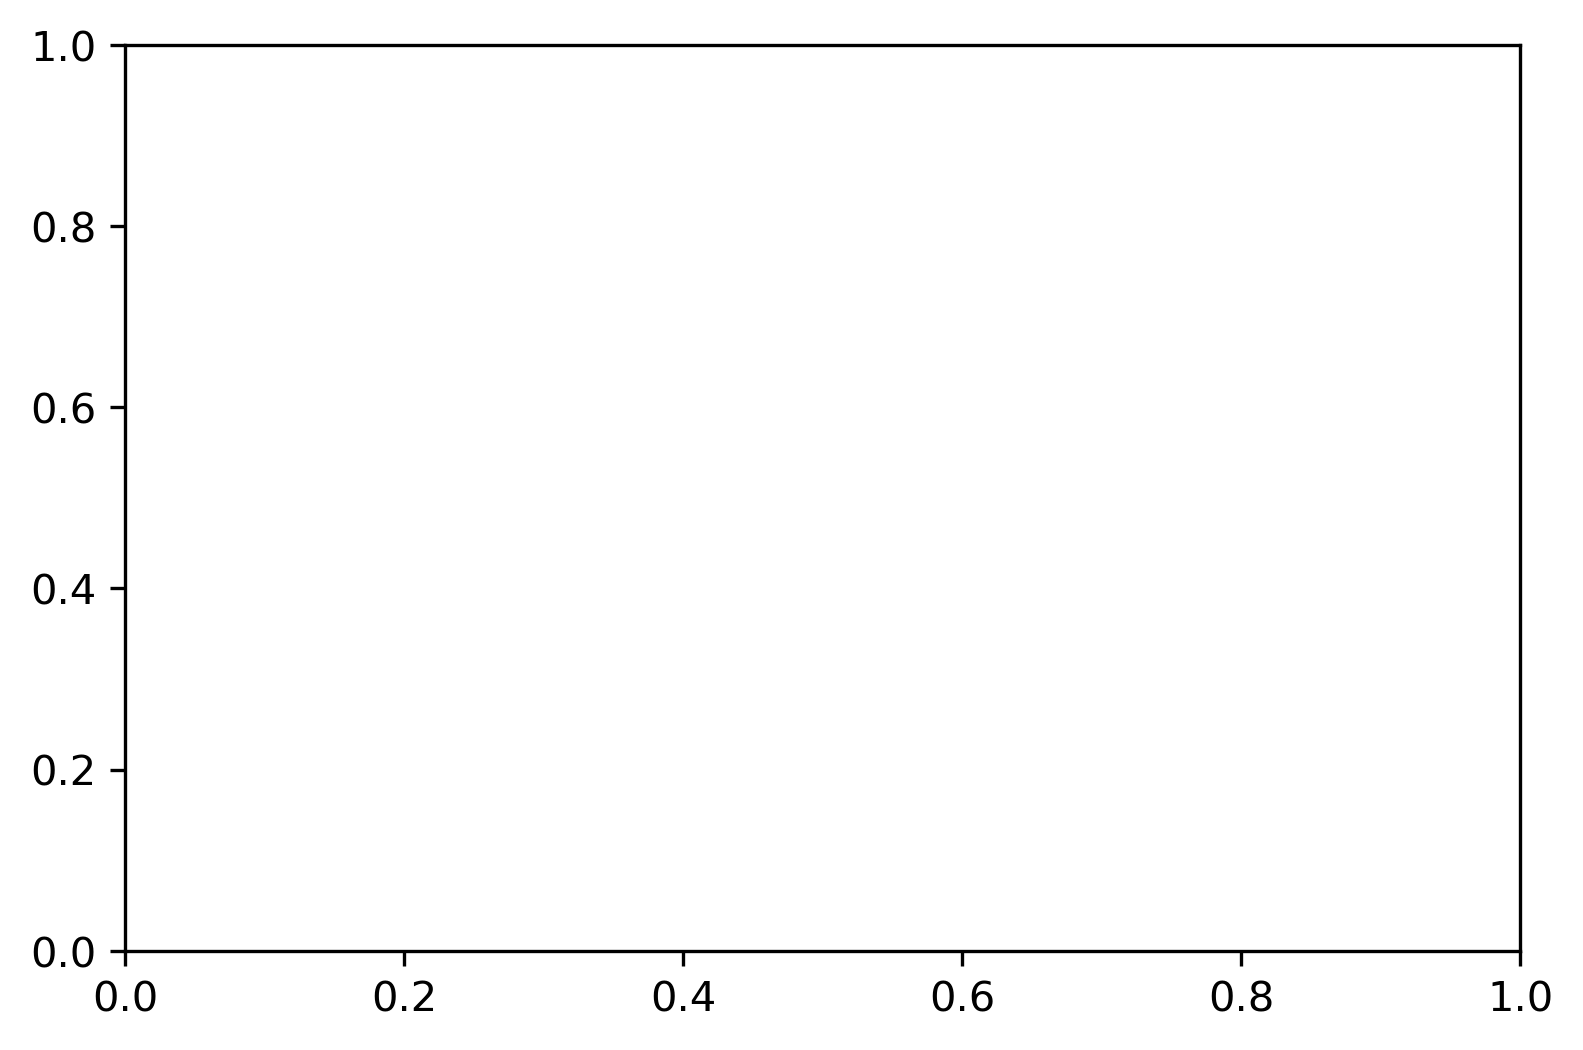

In [169]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal
from PIL import Image

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

def visualize_matches(img_a, img_b, matches, ax=None):
    """Visualize matches between two images. Matches is a list
    such that each element of the list is a 4-element tuple of
    the form [x1, y1, x2, y2]."""
    if ax is None:
        # Create a new axis if none is provided
        fig = plt.figure(dpi=300)
        ax = plt.gca()
    
    # Helper variables
    sa = img_a.shape
    sb = img_b.shape
    sp = 40
    
    # Merge the images and plot matches
    merged_imgs = np.zeros(
        (max(sa[0], sb[0]), sa[1]+sb[1]+sp),
        dtype=np.float)
    merged_imgs[0:sa[0], 0:sa[1]] = img_a
    merged_imgs[0:sb[0], sa[1]+sp:] = img_b
    ax.imshow(merged_imgs)
    
    for m in matches:
        ax.plot([m[0], m[2]+sa[1]+sp], 
                [m[1], m[3]],
                'r', alpha=0.7)

# An example of match visualization
# Stored: [x1, y1, x2, y2]
img_base = load_image('tr_base.png')[:, :, 0]
matches = [
    [1, 3, 1, 3],
    [10, 13, 10, 13],
    [100, 20, 100, 20],
    [30, 100, 30, 100]
]
visualize_matches(img_base, img_base, matches)

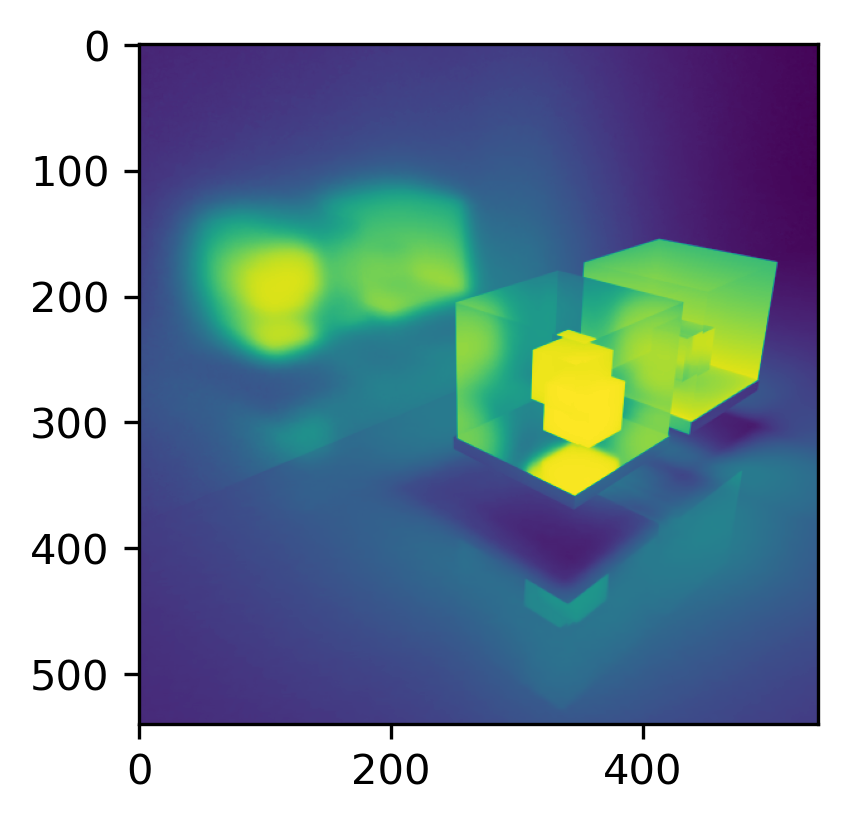

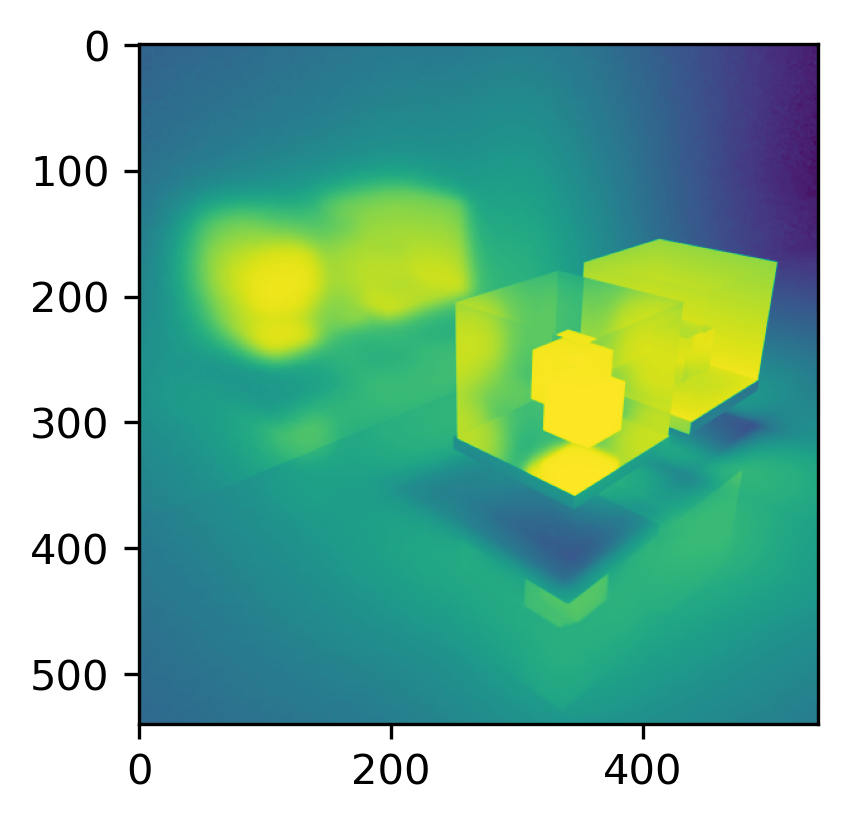

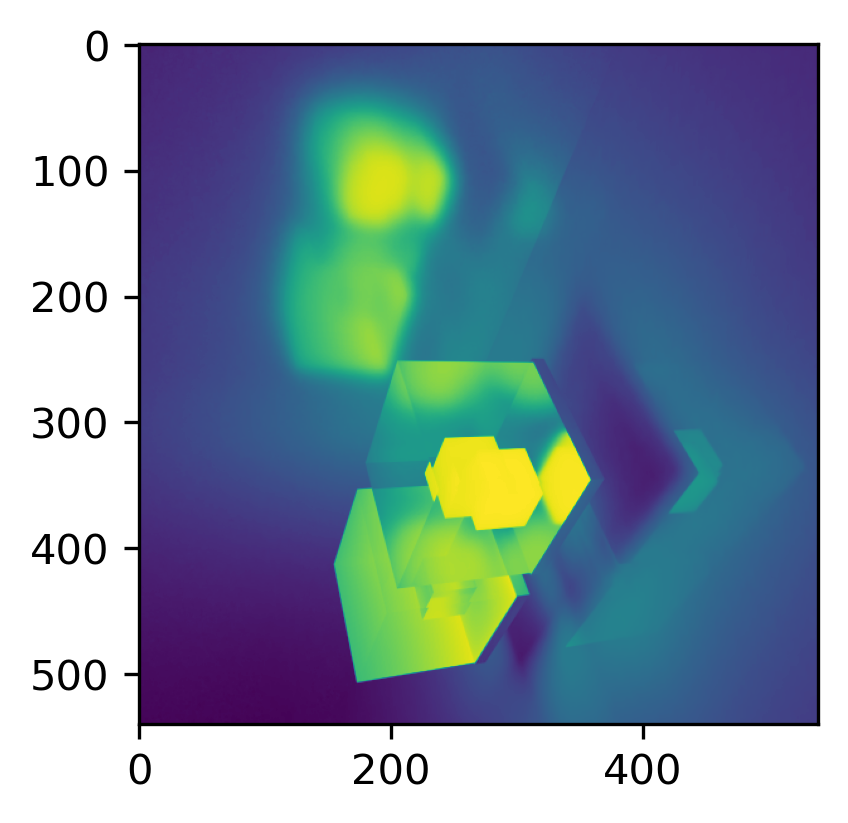

In [175]:
## Computing and Matching Descriptors

# Compute images for matching
img_base = load_image('light_cubes_sm.png')[:, :, 0]
fig = plt.figure(figsize = (3,3), dpi = 300)
plt.imshow(img_base)

img_contrast = img_base ** (0.4)
fig = plt.figure(figsize = (3,3), dpi = 300)
plt.imshow(img_contrast)

img_highres = load_image('light_cubes_base.png')[300:300+img_base.shape[0],
                                                 400:400+img_base.shape[1], 0]
img_transpose = img_base.T
fig = plt.figure(figsize = (3,3), dpi = 300)
plt.imshow(img_transpose)

# TASK: you need to implement Harris Corner Detection
# Set the default 'threshold' to your satisfaction.
def get_corners(image, threshold=0.01):
    """Note: this function assumed to return corners 
    as (x, y) coordinates *not* as (row, column) 
    coordinates."""
    raise NotImplementedError()

def get_features_with_descriptors(image,
                                  corners,
                                  compute_descriptor_fn, 
                                  patch_half_width=7):
    features = []
    for c in corners:
        patch = image[c[1]-patch_half_width:c[1]+patch_half_width+1,
                      c[0]-patch_half_width:c[0]+patch_half_width+1]
        
        # Remove patches too close to the edge
        if patch.size < (2*patch_half_width + 1) ** 2:
            continue
        features.append({
            'x': c[0],
            'y': c[1],
            'patch': patch,
            'descriptor': compute_descriptor_fn(patch),
        })
    
    return features


# Define the various descriptors

def compute_descriptor_match(patch):
    return (patch - np.mean(patch)) / np.std(patch)

def compute_descriptor_binary_x(patch):
    return 2 * ((patch[:-1] - patch[1:]) > 0).astype(float) - 1

def compute_descriptor_hist(patch):
    return np.sqrt(np.histogram(patch, bins=8, range=(0.0, 1.0))[0])


# Define the matching functions

def compare_descriptors(fa, fb):
    return np.sum(fa['descriptor'] * fb['descriptor'])

def compute_feature_matches(fsa, fsb):
    # First compute the strength of the feature response
    sims = np.zeros((len(fsa), len(fsb)), dtype=np.float)
    for ii, fa in enumerate(fsa):
        for jj, fb in enumerate(fsb):
            sims[ii, jj] = compare_descriptors(fa, fb)

    # Now compute the matches
    matches = []
    for ii in range(len(fsa)):
        mi = np.argmax(sims[ii])
        if not ii == np.argmax(sims[:, mi]):
            continue
        match_score = sims[ii, mi]
        matches.append([fsa[ii]['x'],
                        fsa[ii]['y'],
                        fsb[mi]['x'],
                        fsb[mi]['y']])

    return matches

In [9]:
# Descriptor Matching Plotting Code
for (fn, title) in [(compute_descriptor_match, "Match"),
        (compute_descriptor_binary_x, "Binary (x)"),
        (compute_descriptor_hist, "Histogram")]:
    plt.figure(figsize=(12, 6))
    
    corners = get_corners(img_base)
    fsa = get_features_with_descriptors(img_base, corners, fn)
    
    for ind, image_comp in enumerate(
            [img_base, img_contrast, img_highres, img_transpose]):
    
        ax = plt.subplot(2, 2, ind+1)
        corners = get_corners(image_comp)
        fsb = get_features_with_descriptors(image_comp, corners, fn)
        matches = compute_feature_matches(fsa, fsb)
        visualize_matches(img_base, image_comp, matches, ax, title)

NotImplementedError: 

<Figure size 864x432 with 0 Axes>